In [1]:
# Full-CI for 3*4 Hubbard

import numpy as np
import sscps
from pyscf.fci.direct_spin1 import FCISolver
from pyscf.fci.direct_spin1 import energy as fci_energy
from functools import reduce
from hf_Hubbard import HubbardMole, RHF_SpinHubbard
from simple_dmet import DMET_Outer
from dmet_hubbard import DMET_Hubbard
from pyscf.fci.direct_spin1 import absorb_h1e, contract_2e

def ovlp(h1e, eri, ci, ciinv, norb, nelec, link_index=None):
    h2e = absorb_h1e(h1e, eri, norb, nelec, .5)
    ci1 = contract_2e(h2e, ci, norb, nelec, link_index)
    return np.dot(ciinv.reshape(-1), ci1.reshape(-1))

"""
fragments = [
    [[0], [3], [8], [11]],
    [[1], [2], [9], [10]],
    [[4], [7]],
    [[5], [6]]
]
"""


fragments = [[[x]] for x in range(12)]

ehf = [0.]
efci = [0.]
edmet = [0.]
ecps = [0.]
est = [0.]

U = 2

# Scanning the occupation
for n in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]:
    mol = HubbardMole(3, 4, 1, U)
    mol.nelectron = n

    # Hartree Fock
    mf = RHF_SpinHubbard(mol)
    mf.kernel()
    ehf.append(mf.energy_tot())

    # Full CI
    norb = mf.mo_coeff.shape[1]
    h1e = reduce(np.dot, (mf.mo_coeff.T, mf.get_hcore(), mf.mo_coeff))
    eri = np.einsum('mi,mj,mk,ml->ijkl', mf.mo_coeff, mf.mo_coeff, mf.mo_coeff, mf.mo_coeff) * U
    nelec = (n//2, n//2)
    cis = FCISolver(mol)
    e = cis.kernel(h1e, eri, norb, nelec, davidson_only=True)[0]
    print("FCI energy = ", e)
    efci.append(e)

    # DMET
    dmet_outer = DMET_Outer(mf, fragments, dmetclass=DMET_Hubbard)
    dmet_outer.chempot_cycle()
    e = dmet_outer.inner_kernel()[0]
    print("DMET Energy = ", e)
    edmet.append(e)

    # CPS

    clm = mf.mo_coeff[:,np.argsort(mf.mo_energy)[:n//2]]   
    ci_slater = sscps.ci_slater(12, (n//2, n//2), clm)

    k = 0

    coef_fcis = []
    coef_hfs = []

    for sym_frag in fragments:
        dmet_scf = dmet_outer.dmets[k]
        cis = FCISolver(mol)
        e, coef_fci = cis.kernel(dmet_scf.get_hcore(), dmet_scf.erifb, 2, 2)
        coef_fcis.append(coef_fci)

        k += 1


    k = 0
    # dmet_outer.chempot_cycle(method="hf")
    for sym_frag in fragments:
        dmet_scf = dmet_outer.dmets[k]
        dmet_scf.rhf()

        e, c = dmet_scf.mo_energy, dmet_scf.mo_coeff
        c = c[:,np.argsort(e)[0]]
        coef_hf = np.einsum("i,j->ij", c, c)
        coef_hfs.append(coef_hf)

        k += 1

    k = 0

    ps = np.zeros((12,4))

    for sym_frag in fragments:
        proj = (coef_fcis[k] / coef_hfs[k]).reshape(-1)
        
        for frag in sym_frag:
            ps[frag[0]] = proj

        k += 1

    psinv = 1. / ps

    cinn = sscps.ci_sscps(12, (n//2, n//2), ci_slater, ps, normalized=False)
    ci = sscps.ci_sscps(12, (n//2, n//2), ci_slater, ps, normalized=True)
    ciinvnn = sscps.ci_sscps(12, (n//2, n//2), ci_slater, psinv, normalized=False)

    h1e = mf.get_hcore()
    eri = mf._eri
    e = fci_energy(h1e, eri, ci, 12, (n//2, n//2))

    print("CPS Energy = ", e)
    ecps.append(e)

    e = ovlp(h1e, eri, cinn, ciinvnn, 12, (n//2, n//2))
    print("CPS ST Energy = ", e)
    est.append(e)

ehf = np.array(ehf)
efci = np.array(efci)
edmet = np.array(edmet)
ecpsva = np.array(ecps)
ecpsst = np.array(est)


converged SCF energy = -5.84738126022089


Initialize <hf_Hubbard.HubbardMole object at 0x7f9ab9be6160> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9ac832adf0>
<class 'hf_Hubbard.HubbardMole'> does not have attributes  t lx ly U


FCI energy =  -5.898160826583078
DMET Energy =  -5.9044471651285475
converged SCF energy = -0.220571156247422
converged SCF energy = -0.526499856402601
converged SCF energy = -0.526499856402601
converged SCF energy = -0.220571156247422
converged SCF energy = -0.41920945470685


<class 'dmet_hubbard.DMET_Hubbard'> does not have attributes  un_dm cal fb_coeff dm fragment bath_coeff nocc erifb frag_coeff na mu_glob un_coeff


converged SCF energy = -0.983310659113243
converged SCF energy = -0.983310659113243
converged SCF energy = -0.41920945470685
converged SCF energy = -0.220571156247422
converged SCF energy = -0.526499856402602
converged SCF energy = -0.526499856402601
converged SCF energy = -0.220571156247422
Norm =  0.7762403113845956
Norm =  0.7762403113845956
Norm =  1.3050524535464976
CPS Energy =  -5.879120657994044
CPS ST Energy =  -5.909795418325524
converged SCF energy = -9.39643915729498


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e83bcd0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e83b760>


FCI energy =  -9.56704299357496
DMET Energy =  -9.598636028568144
converged SCF energy = -0.547561067948122
converged SCF energy = -0.666352243035616
converged SCF energy = -0.666352243035616
converged SCF energy = -0.547561067946525
converged SCF energy = -1.00659047610052
converged SCF energy = -1.21320052946441
converged SCF energy = -1.21320052946441
converged SCF energy = -1.00659047609962
converged SCF energy = -0.547561067946525
converged SCF energy = -0.66635224303315
converged SCF energy = -0.666352243035617
converged SCF energy = -0.547561067944933
Norm =  0.8423143313290202
Norm =  0.8423143313290202
Norm =  1.2362536529964927
CPS Energy =  -9.507125588760424
CPS ST Energy =  -9.635857044917586
converged SCF energy = -11.827460481314


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e820190> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e8203a0>


FCI energy =  -12.148181865824187
DMET Energy =  -12.23494864795955
converged SCF energy = -0.725021218691067
converged SCF energy = -1.07957083366738
converged SCF energy = -1.07957083366774
converged SCF energy = -0.725021218691706
converged SCF energy = -1.04182509398271
converged SCF energy = -1.23200692850105
converged SCF energy = -1.23200692850174
converged SCF energy = -1.04182509398404
converged SCF energy = -0.725021218691067
converged SCF energy = -1.07957083366756
converged SCF energy = -1.07957083366756
converged SCF energy = -0.725021218691706
Norm =  0.900984403331593
Norm =  0.900984403331593
Norm =  1.1620054764071912
CPS Energy =  -12.07500574733045
CPS ST Energy =  -12.27930738138411
converged SCF energy = -12.2560434022122


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e820370> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e8205b0>


FCI energy =  -12.813768363288581
DMET Energy =  -12.896173927989809
converged SCF energy = -0.772071353563061
converged SCF energy = -1.10657457924395
converged SCF energy = -1.10657457924396
converged SCF energy = -0.772071353563532
converged SCF energy = -1.10688544808501
converged SCF energy = -1.27931155740395
converged SCF energy = -1.27931155740395
converged SCF energy = -1.106885448085
converged SCF energy = -0.772071353563532
converged SCF energy = -1.10657457924383
converged SCF energy = -1.10657457924408
converged SCF energy = -0.772071353563061
Norm =  0.9546028626012322
Norm =  0.9546028626012322
Norm =  1.1025333040322551
CPS Energy =  -12.662829367140644
CPS ST Energy =  -13.056145085840384
converged SCF energy = -11.9833516566873


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e8752e0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9ac867f670>


FCI energy =  -12.658382736555978
DMET Energy =  -12.81781222273515
converged SCF energy = -0.759582374382687
converged SCF energy = -1.07708562608088
converged SCF energy = -1.07708562608655
converged SCF energy = -0.759582374382687
converged SCF energy = -1.07058604674564
converged SCF energy = -1.29082515335207
converged SCF energy = -1.29082515335207
converged SCF energy = -1.07058604674564
converged SCF energy = -0.759582374382687
converged SCF energy = -1.07708562608088
converged SCF energy = -1.07708562608655
converged SCF energy = -0.759582374382688
Norm =  0.997539099288845
Norm =  0.997539099288845
Norm =  1.0389112381053915
CPS Energy =  -12.527128655509136
CPS ST Energy =  -12.971524929201543
converged SCF energy = -10.6011261594915


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e875c70> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e875a00>


FCI energy =  -11.481875713772379
DMET Energy =  -11.541547574768936
converged SCF energy = -0.682490743212625
converged SCF energy = -0.943681107702731
converged SCF energy = -0.943681107702733
converged SCF energy = -0.682490743212446
converged SCF energy = -0.993461161054268
converged SCF energy = -1.05346718932395
converged SCF energy = -1.05346718932395
converged SCF energy = -0.993461161054267
converged SCF energy = -0.682490743212445
converged SCF energy = -0.943681107702732
converged SCF energy = -0.943681107702732
converged SCF energy = -0.682490743212445
Norm =  0.9999999999999947
Norm =  0.9999999999999947
Norm =  1.0371230363968595
CPS Energy =  -11.2377711296509
CPS ST Energy =  -11.839053477698343
converged SCF energy = -7.98335165668733


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e82d190> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e82d1f0>


FCI energy =  -8.658382736556009
DMET Energy =  -8.857890444903388
converged SCF energy = -0.530302214765776
converged SCF energy = -0.702889081935711
converged SCF energy = -0.702889081935711
converged SCF energy = -0.530302214785588
converged SCF energy = -0.731119280008688
converged SCF energy = -0.685388736792377
converged SCF energy = -0.685388736745241
converged SCF energy = -0.731119280008689
converged SCF energy = -0.530302214765777
converged SCF energy = -0.702889081935711
converged SCF energy = -0.702889081935712
converged SCF energy = -0.530302214805371
Norm =  0.9973071692128925
Norm =  0.9973071692128925
Norm =  1.0392419701963689
CPS Energy =  -8.527693730937525
CPS ST Energy =  -8.970828666431585
converged SCF energy = -4.25604340221224


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e82dc10> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e82db80>


FCI energy =  -4.813768363288567
DMET Energy =  -4.921641152940401
converged SCF energy = 0.0827767885483983
converged SCF energy = -0.40829536615235
converged SCF energy = -0.408295366152005
converged SCF energy = 0.0827767885514515
converged SCF energy = -0.627614999679613
converged SCF energy = -0.577357638199279
converged SCF energy = -0.577357638199281
converged SCF energy = -0.627614999675505
converged SCF energy = 0.0827767885474345
converged SCF energy = -0.408295366152005
converged SCF energy = -0.408295366152352
converged SCF energy = 0.0827767885564317
Norm =  0.9537939323514851
Norm =  0.9537939323514851
Norm =  1.1034861037283963
CPS Energy =  -4.664313886297129
CPS ST Energy =  -5.052322734653645
converged SCF energy = 0.172539518686028


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e7f4ee0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e7f4ca0>


FCI energy =  -0.14818186582405077
DMET Energy =  -0.23315076731238704
converged SCF energy = 0.490644338071252
converged SCF energy = -0.204392094926609
converged SCF energy = -0.20439209492661
converged SCF energy = 0.49064433807125
converged SCF energy = -0.0199992209485844
converged SCF energy = -0.191205683294513
converged SCF energy = -0.191205683294515
converged SCF energy = -0.019999220955204
converged SCF energy = 0.490644338071251
converged SCF energy = -0.20439209492661
converged SCF energy = -0.204392094926609
converged SCF energy = 0.49064433806863
Norm =  0.9005165114488032
Norm =  0.9005165114488032
Norm =  1.1624570090490336
CPS Energy =  -0.07508270330244586
CPS ST Energy =  -0.27910032887721087
converged SCF energy = 6.60356084270501


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e80c280> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e80c250>


FCI energy =  6.432957006425001
DMET Energy =  6.404689087516102
converged SCF energy = 0.946016377160421
converged SCF energy = 0.823466840222956
converged SCF energy = 0.823466840222961
converged SCF energy = 0.946016377160427
converged SCF energy = 0.0893835616357039
converged SCF energy = -0.120940580350385
converged SCF energy = -0.120940580359325
converged SCF energy = 0.0893835616282952
converged SCF energy = 0.946016377160426
converged SCF energy = 0.823466840222959
converged SCF energy = 0.823466840222959
converged SCF energy = 0.946016377160425
Norm =  0.842249512166871
Norm =  0.842249512166871
Norm =  1.2362224569910791
CPS Energy =  6.49271797220317
CPS ST Energy =  6.364189259440602
converged SCF energy = 14.1526187397791


Initialize <hf_Hubbard.HubbardMole object at 0x7f9ab9be6160> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e7f4370>


FCI energy =  14.101839173416773
DMET Energy =  14.095813970489504
converged SCF energy = 1.62679738313602
converged SCF energy = 1.11835609560331
converged SCF energy = 1.11835609560331
converged SCF energy = 1.62679738313602
converged SCF energy = 1.29596972514363
converged SCF energy = 0.36396050174138
converged SCF energy = 0.36396050174138
converged SCF energy = 1.29596972514363
converged SCF energy = 1.62679738313602
converged SCF energy = 1.11835609560331
converged SCF energy = 1.11835609560331
converged SCF energy = 1.62679738313602
Norm =  0.7760728824544156
Norm =  0.7760728824544156
Norm =  1.305371378737839
CPS Energy =  14.120876472500402
CPS ST Energy =  14.090206941551791
converged SCF energy = 24
FCI energy =  24.0


Initialize <hf_Hubbard.HubbardMole object at 0x7f9a4e7f41c0> in <hf_Hubbard.RHF_SpinHubbard object at 0x7f9a4e875fd0>


DMET Energy =  23.999998099558656
converged SCF energy = 1.99999996902583
converged SCF energy = 1.9999999753741
converged SCF energy = 1.99999997538782
converged SCF energy = 1.99999976154494
converged SCF energy = 1.99999990251193
converged SCF energy = 1.99999911600703
converged SCF energy = 1.99999968504584
converged SCF energy = 1.99999983551673
converged SCF energy = 1.99999998453613
converged SCF energy = 1.99999991382508
converged SCF energy = 1.99999998589291
converged SCF energy = 1.99999999489031
Norm =  0.9999994130361913
Norm =  0.9999994130361913
Norm =  1.0000005869641577
CPS Energy =  24.000000000000004
CPS ST Energy =  24.000000000000114


In [2]:
nocc = np.linspace(0, 24, 13) / 24

import pandas as pd

ehf = ehf / 12
efci /= 12
edmet /= 12
ecpsva /= 12
ecpsst /= 12


df = pd.read_csv("data_Hub_34_U=2.csv")
df["CPS-VA-1S"] = ecpsva
df["CPS-ST-1S"] = ecpsst

In [3]:
df

OCC        HF       FCI   DMET-1S  CPS-VA-1S  CPS-ST-1S
0   0.000000  0.000000  0.000000  0.000000   0.000000   0.000000
1   0.083333 -0.487282 -0.491513 -0.492037  -0.489927  -0.492483
2   0.166667 -0.783037 -0.797254 -0.799886  -0.792260  -0.802988
3   0.250000 -0.985622 -1.012348 -1.019579  -1.006250  -1.023276
4   0.333333 -1.021337 -1.067814 -1.074681  -1.055236  -1.088012
5   0.416667 -0.998613 -1.054865 -1.068151  -1.043927  -1.080960
6   0.500000 -0.883427 -0.956823 -0.961796  -0.936481  -0.986588
7   0.583333 -0.665279 -0.721532 -0.738158  -0.710641  -0.747569
8   0.666667 -0.354670 -0.401147 -0.410137  -0.388693  -0.421027
9   0.750000  0.014378 -0.012348 -0.019429  -0.006257  -0.023258
10  0.833333  0.550297  0.536080  0.533724   0.541060   0.530349
11  0.916667  1.179385  1.175153  1.174651   1.176740   1.174184
12  1.000000  2.000000  2.000000  2.000000   2.000000   2.000000

In [5]:
df.to_csv("data_Hub_34_U=2.csv", index=False)

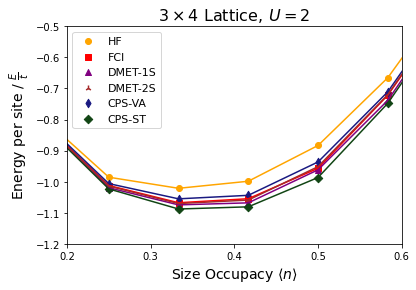

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data_Hub_34_U=2.csv")

ehf = df['HF']
efci = df['FCI']
edmet = df['DMET-1S']
ecpsva = df['CPS-VA-1S']
ecpsst = df['CPS-ST-1S']
edmet2 = df['DMET-2S']
nocc = df['OCC']


plt.plot(nocc, ehf, color="orange")
plt.plot(nocc, efci, color="red")
plt.plot(nocc, edmet, color="purple")
plt.plot(nocc, ecpsva, color="#191981")
plt.plot(nocc, ecpsst, color="#114514")
plt.plot(nocc, edmet2, color="brown")

plt.scatter(nocc, ehf, color="orange", label='HF')
plt.scatter(nocc, efci, color="red", marker='s', label='FCI')
plt.scatter(nocc, edmet, color="purple", marker='^', label='DMET-1S')
plt.scatter(nocc, edmet2, color="brown", marker='2', label='DMET-2S')
plt.scatter(nocc, ecpsva, color="#191981", marker='d', label='CPS-VA')
plt.scatter(nocc, ecpsst, color="#114514", marker='D', label='CPS-ST')


plt.plot()
plt.legend(fontsize=11)
plt.xlim(0.2, 0.6)
plt.xticks([0.2,0.3,0.4,0.5,0.6])
plt.ylim(-1.2,-0.5)
plt.xlabel("Size Occupacy " + r"$\langle n \rangle$", fontsize=14)
plt.ylabel("Energy per site / " + r"$\frac{E}{t}$", fontsize=14)
plt.title(r"$3\times 4\,\,\mathrm{Lattice},\, U = 2$", fontsize=16)
plt.show()

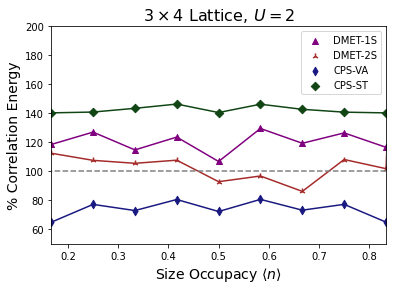

In [25]:
cdmet = (edmet-ehf)/(efci-ehf)
ccpsva = (ecpsva-ehf)/(efci-ehf)
ccpsst = (ecpsst-ehf)/(efci-ehf)
cdmet2 = (edmet2-ehf)/(efci-ehf)

cdmet[0] = 1; cdmet[12] = 1
ccpsva[0] = 1; ccpsva[12] = 1
ccpsst[0] = 1; ccpsst[12] = 1
cdmet2[0] = 1; cdmet2[12] = 1

plt.plot(nocc, cdmet * 100, color="purple")
plt.plot(nocc, ccpsva * 100, color="#191981")
plt.plot(nocc, ccpsst * 100, color="#114514")
plt.plot(nocc, cdmet2 * 100, color='brown')


plt.scatter(nocc, cdmet * 100, color="purple", marker='^', label='DMET-1S')
plt.scatter(nocc, cdmet2 * 100, color='brown', marker='2', label='DMET-2S')
plt.scatter(nocc, ccpsva * 100, color="#191981", marker='d', label='CPS-VA')
plt.scatter(nocc, ccpsst * 100, color="#114514", marker='D', label='CPS-ST')

plt.xlabel("Size Occupacy " + r"$\langle n \rangle$", fontsize=14)
plt.ylabel("% Correlation Energy", fontsize=14)
plt.xlim(0.166666, 0.833333)
plt.ylim(50, 200)
plt.legend()
plt.title(r"$3\times 4\,\,\mathrm{Lattice},\, U = 2$", fontsize=16)
plt.hlines(100, 0, 1, colors='grey', linestyles="--")
plt.show()